In [2]:
!pip install pretty_midi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=f6c31c517e728d4e78b027c4e47137281670100f0048c67075a41a14de780dfa
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [7]:

import os
import numpy as np
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [8]:
# Dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/datasets/maestro-v3.0.0"
metadata_file = os.path.join(dataset_path, "maestro-v3.0.0.csv")

# Load metadata and filter year
df = pd.read_csv(metadata_file)
selected_years = [2017]
df = df[df['year'].isin(selected_years)]

# List of MIDI files
midi_files = [os.path.join(dataset_path, f) for f in df['midi_filename'].tolist()]


In [9]:
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in pm.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            notes.append([note.start, note.end, note.pitch, note.velocity])
    return np.array(notes)

all_notes = [midi_to_notes(f) for f in midi_files]
all_notes = np.concatenate(all_notes, axis=0)


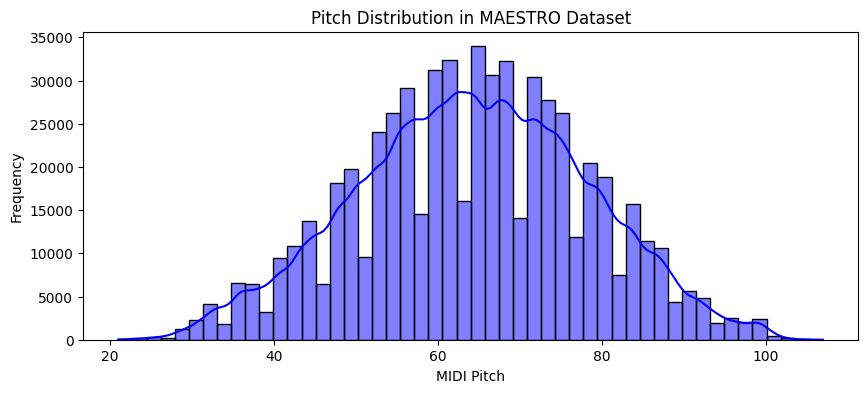

In [10]:
plt.figure(figsize=(10, 4))
sns.histplot(all_notes[:, 2], bins=50, kde=True, color="blue")
plt.xlabel("MIDI Pitch")
plt.ylabel("Frequency")
plt.title("Pitch Distribution in MAESTRO Dataset")
plt.show()


In [11]:
def midi_to_piano_roll(midi_file, fs=100):
    pm = pretty_midi.PrettyMIDI(midi_file)
    piano_roll = pm.get_piano_roll(fs=fs)
    return piano_roll.T

piano_rolls = [midi_to_piano_roll(f) for f in midi_files]

# Pad or truncate to fixed length
max_length = 1000
piano_rolls = [x[:max_length] if x.shape[0] > max_length else np.pad(x, ((0, max_length - x.shape[0]), (0, 0))) for x in piano_rolls]

X = np.array(piano_rolls)
max_val = np.max(X)
print(max_val)


114.0


In [12]:
X_train, X_temp = train_test_split(X, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

X_train = X_train / max_val
X_val = X_val / max_val
X_test = X_test / max_val

print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")


Training Data Shape: (112, 1000, 128)
Validation Data Shape: (14, 1000, 128)
Test Data Shape: (14, 1000, 128)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization, UpSampling1D

def build_cnn_lstm(input_shape=(1000, 128)):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(UpSampling1D(size=2))
    model.add(UpSampling1D(size=2))

    model.add(TimeDistributed(Dense(128, activation='sigmoid')))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (1000, 128)
model = build_cnn_lstm(input_shape)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1000, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 250, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1000, 128)      │         8,320 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,424 (935.25 KB)

 Trainable params: 239,040 (933.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
# Train Model
history = model.fit(
    X_train, X_train,  # Autoencoder-style training
    epochs=200,
    batch_size=8,
    validation_data=(X_val, X_val)
)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0110 - loss: 0.6672 - val_accuracy: 0.0195 - val_loss: 0.5255
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.0134 - loss: 0.4219 - val_accuracy: 0.0000e+00 - val_loss: 0.2156
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.0253 - loss: 0.1960 - val_accuracy: 0.0000e+00 - val_loss: 0.1155
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.0356 - loss: 0.1144 - val_accuracy: 0.0000e+00 - val_loss: 0.0866
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0281 - loss: 0.0883 - val_accuracy: 0.0257 - val_loss: 0.0766
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0252 - loss: 0.0791 - val_accuracy: 0.0257 - val_loss: 0.0720
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.0243 - loss: 0.0801 - val_accuracy: 0.0367 - val_loss: 0.0693
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.0256 - loss: 0.0729

In [15]:
# Evaluate Model on Test Data
loss, accuracy = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4018 - loss: 0.0379
Test Loss: 0.0379, Test Accuracy: 0.4018


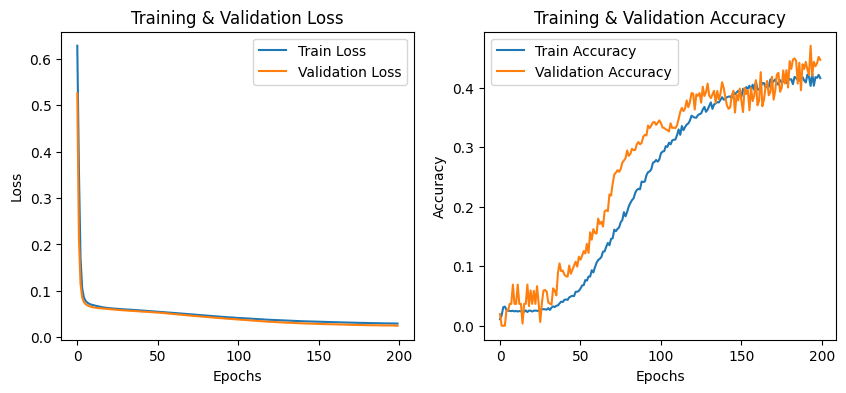

In [16]:
# Plot Training & Validation History
plt.figure(figsize=(10, 4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [17]:
# Generate Music Sequence for One Test Sample
generated_sequence = model.predict(X_test[:1])
print(generated_sequence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[[[2.4248958e-04 3.6425005e-05 5.1011106e-05 ... 5.0005056e-05
   3.8955808e-05 6.3580977e-05]
  [2.4248958e-04 3.6425005e-05 5.1011106e-05 ... 5.0005056e-05
   3.8955808e-05 6.3580977e-05]
  [2.4248958e-04 3.6425005e-05 5.1011106e-05 ... 5.0005056e-05
   3.8955808e-05 6.3580977e-05]
  ...
  [8.0088694e-06 5.1437172e-07 8.1587115e-07 ... 8.1891670e-07
   5.5145046e-07 1.2493892e-06]
  [8.0088694e-06 5.1437172e-07 8.1587115e-07 ... 8.1891670e-07
   5.5145046e-07 1.2493892e-06]
  [8.0088694e-06 5.1437172e-07 8.1587115e-07 ... 8.1891670e-07
   5.5145046e-07 1.2493892e-06]]]


In [18]:
# Function to Convert Generated Sequence to MIDI
def piano_roll_to_midi(piano_roll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    for time, pitch_vector in enumerate(piano_roll):
        for pitch, velocity in enumerate(pitch_vector):
            if velocity > 0:
                note = pretty_midi.Note(
                    velocity=int(velocity * 127),
                    pitch=pitch,
                    start=time / fs,
                    end=(time + 1) / fs
                )
                instrument.notes.append(note)
    pm.instruments.append(instrument)
    return pm

# Convert and Save Generated MIDI File
generated_midi = piano_roll_to_midi(generated_sequence[0])
generated_midi.write("generated_music.mid")
print("Generated MIDI saved as 'generated_music.mid'")


Generated MIDI saved as 'generated_music.mid'
